In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import sklearn


#Plotting parameters
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)


In [2]:
climacell =  pd.read_csv('climacell_data_formodel.csv')

In [3]:
climacell

,date_time,date,time,irradiance,ambient_temp,wind_speed
0,2020-08-20 06:05:00+05:30,20-08-2020,06:05:00,0,28.58,6.33
1,2020-08-20 06:10:00+05:30,20-08-2020,06:10:00,0,28.57,6.26
2,2020-08-20 06:15:00+05:30,20-08-2020,06:15:00,0,28.57,6.18
3,2020-08-20 06:20:00+05:30,20-08-2020,06:20:00,0,28.56,6.11
4,2020-08-20 06:25:00+05:30,20-08-2020,06:25:00,0,28.56,6.03
...,...,...,...,...,...,...
2947,2020-10-20 11:40:00+05:30,20-10-2020,11:40:00,322,30.24,3.10
2948,2020-10-20 11:45:00+05:30,20-10-2020,11:45:00,322,30.25,3.14
2949,2020-10-20 11:50:00+05:30,20-10-2020,11:50:00,322,30.26,3.19
2950,2020-10-20 11:55:00+05:30,20-10-2020,11:55:00,322,30.26,3.24


In [4]:
df = pd.read_csv('weather_data_from_plant.csv')

In [5]:
df

,date_time,ambient_temp,wind_speed,irradiance
0,2020-08-21T06:26:01.000Z,28.185780,0.28164,0.000000
1,2020-08-21T06:27:01.000Z,28.185780,0.28164,0.000000
2,2020-08-21T06:28:01.000Z,28.185780,0.28164,0.000000
3,2020-08-21T06:29:01.000Z,28.185780,0.28164,0.000000
4,2020-08-21T06:30:01.000Z,28.170719,0.28164,3.442247
...,...,...,...,...
79907,2020-10-20T12:57:01.000Z,36.253342,0.28164,749.843811
79908,2020-10-20T12:58:01.000Z,36.238201,1.88136,753.283386
79909,2020-10-20T12:59:01.000Z,36.088779,0.28164,753.283386
79910,2020-10-20T13:00:01.000Z,35.983109,0.28164,753.283386


In [6]:
df = df.fillna(0)
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79912 entries, 0 to 79911
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date_time     79912 non-null  object 
 1   ambient_temp  79912 non-null  float64
 2   wind_speed    79912 non-null  float64
 3   irradiance    79912 non-null  float64
dtypes: float64(3), object(1)
memory usage: 2.4+ MB


In [7]:
df['date_time'] = pd.to_datetime(df['date_time']).dt.tz_convert('Asia/Kolkata')
df = df.set_index('date_time')
df.head()

,ambient_temp,wind_speed,irradiance
date_time,,,
2020-08-21 11:56:01+05:30,28.185780,0.28164,0.000000
2020-08-21 11:57:01+05:30,28.185780,0.28164,0.000000
2020-08-21 11:58:01+05:30,28.185780,0.28164,0.000000
2020-08-21 11:59:01+05:30,28.185780,0.28164,0.000000
2020-08-21 12:00:01+05:30,28.170719,0.28164,3.442247


In [8]:
df

,ambient_temp,wind_speed,irradiance
date_time,,,
2020-08-21 11:56:01+05:30,28.185780,0.28164,0.000000
2020-08-21 11:57:01+05:30,28.185780,0.28164,0.000000
2020-08-21 11:58:01+05:30,28.185780,0.28164,0.000000
2020-08-21 11:59:01+05:30,28.185780,0.28164,0.000000
2020-08-21 12:00:01+05:30,28.170719,0.28164,3.442247
...,...,...,...
2020-10-20 18:27:01+05:30,36.253342,0.28164,749.843811
2020-10-20 18:28:01+05:30,36.238201,1.88136,753.283386
2020-10-20 18:29:01+05:30,36.088779,0.28164,753.283386


### Sample the dataset to contain one hour data 

12:00 am 13:00am , etc

In [9]:
df = df.asfreq('H')
df

,ambient_temp,wind_speed,irradiance
date_time,,,
2020-08-21 11:56:01+05:30,28.185780,0.28164,0.000000
2020-08-21 12:56:01+05:30,28.456940,0.28164,48.187481
2020-08-21 13:56:01+05:30,28.848610,0.28164,127.351303
2020-08-21 14:56:01+05:30,29.149891,0.28164,216.841507
2020-08-21 15:56:01+05:30,29.888050,0.28164,99.814743
...,...,...,...
2020-10-20 13:56:01+05:30,29.872990,0.28164,254.702103
2020-10-20 14:56:01+05:30,31.268909,2.68122,461.066406
2020-10-20 15:56:01+05:30,33.281879,1.08150,643.427978


## Now, we have hourly data 

## Fitting a baseline naive model that just predict's the currunt value as the next value

### Splitting the dataset

In [10]:
split = int(df.shape[0]*0.7)

In [11]:
split = int(df.shape[0]*0.7)
train_df = df[:split]
test_df = df[split:]

In [12]:
train_df,test_df

(                           ambient_temp  wind_speed  irradiance
 date_time                                                      
 2020-08-21 11:56:01+05:30     28.185780     0.28164    0.000000
 2020-08-21 12:56:01+05:30     28.456940     0.28164   48.187481
 2020-08-21 13:56:01+05:30     28.848610     0.28164  127.351303
 2020-08-21 14:56:01+05:30     29.149891     0.28164  216.841507
 2020-08-21 15:56:01+05:30     29.888050     0.28164   99.814743
 ...                                 ...         ...         ...
 2020-10-02 10:56:01+05:30     27.094730     0.28164    0.000000
 2020-10-02 11:56:01+05:30     27.138161     0.28164    0.000000
 2020-10-02 12:56:01+05:30     27.261829     0.28164  110.151001
 2020-10-02 13:56:01+05:30     28.336430     1.88136  344.192810
 2020-10-02 14:56:01+05:30     29.760260     1.08150  536.787170
 
 [1012 rows x 3 columns],
                            ambient_temp  wind_speed  irradiance
 date_time                                                    

In [13]:
naive_forecast = df[split - 1:-1]
naive_forecast

,ambient_temp,wind_speed,irradiance
date_time,,,
2020-10-02 14:56:01+05:30,29.760260,1.08150,536.787170
2020-10-02 15:56:01+05:30,31.043110,1.08150,729.444824
2020-10-02 16:56:01+05:30,32.272419,0.28164,846.435120
2020-10-02 17:56:01+05:30,33.702839,2.68122,887.660095
2020-10-02 18:56:01+05:30,34.741581,1.08150,873.734070
...,...,...,...
2020-10-20 12:56:01+05:30,28.080339,0.28164,68.841080
2020-10-20 13:56:01+05:30,29.872990,0.28164,254.702103
2020-10-20 14:56:01+05:30,31.268909,2.68122,461.066406


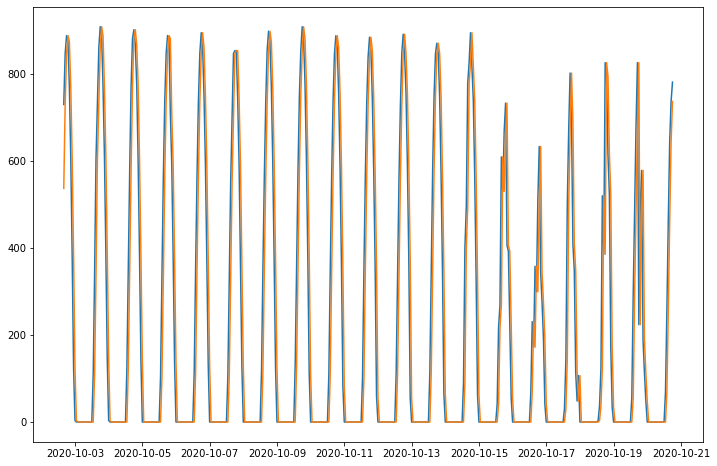

In [14]:
plt.plot(test_df.index,test_df['irradiance'])
plt.plot(test_df.index,naive_forecast['irradiance'])
plt.show()

In [15]:
from sklearn import metrics

def print_score(pred,actual):
    print("Root Mean Squared Error : ",np.sqrt(keras.metrics.mean_squared_error(pred,actual).numpy()))
    print("Mean Absolute Error : ",keras.metrics.mean_absolute_error(pred,actual).numpy())
    print("Mean Absolute Percentage Error : ",keras.metrics.mean_absolute_percentage_error(pred,actual).numpy())

    print("R2 Score : ",sklearn.metrics.r2_score(pred,actual))

In [16]:
print_score(test_df['irradiance'],naive_forecast['irradiance'])

Root Mean Squared Error :  123.64308003866569
Mean Absolute Error :  74.70675639990804
Mean Absolute Percentage Error :  3194697000.111689
R2 Score :  0.8488371216701203


## Statistical ARIMA Model

------------------------------

In [17]:
from statsmodels.tsa.arima_model import ARIMA

In [18]:
import tensorflow as tf
import numpy as np

## MLP Model

### Convert the sequence to windowed format

In [19]:
from numpy import array

def mmo_window(s,ws,wo):

    #ws : window size
    #wo : output step size

    X = list()
    y = list()

    for i in range(len(s)):
        #Window from i to i+ws
        end_ix = i + ws
        if end_ix > len(s) - 1:
            break
        
        end_ix_o = end_ix + wo
        if end_ix_o > len(s):
            break


        seq_x = s[i:end_ix].fillna(0)
        seq_y = s.iloc[end_ix:end_ix_o,-1].fillna(0)

        X.append(seq_x)
        y.append(seq_y)

    X = array(X)
    y = array(y)

    return X,y






In [20]:
window = 24
step = 24


X_train,y_train = mmo_window(train_df,window,step)
X_test,y_test = mmo_window(test_df,window,step)

In [21]:
y_train.shape

(965, 24)

In [22]:
print(y_train[0])

[  0.          96.38361359 309.7726135  306.2402039  381.9269104
 416.3357849  361.2832947  392.2503967  498.9099121  698.3297119
 127.2749023   10.32516956   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]


In [23]:
X_train.shape

(965, 24, 3)

### Reshape the input from (rows,window,no_of_columns) to (rows,window*no_of_columns)

#### No of nuerons in input layer = window*no_of_columns

In [24]:
inp_shape = X_train.shape[1]*X_train.shape[2]

X_train = X_train.reshape((X_train.shape[0],inp_shape))
X_test = X_test.reshape((X_test.shape[0],inp_shape))

print(X_train.shape, " ", X_test.shape)

(965, 72)   (388, 72)


In [25]:
X_train.shape

(965, 72)

### A Shallow MLP Model
##### Input Nuerons = Window size * no of features (3 in this case)
##### Output Nuerons = step size


In [26]:
from tensorflow.keras import optimizers

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100,activation='relu',input_dim=inp_shape))
model.add(tf.keras.layers.Dense(step))
model.compile(optimizer='adam',loss='mse')

In [27]:
y_train.shape

(965, 24)

In [28]:
model.fit(X_train,y_train,epochs=50)

Epoch 1/50
31/31 [==============================] - 1s 2ms/step - loss: 111491.6233
Epoch 2/50
31/31 [==============================] - 0s 2ms/step - loss: 51392.6373
Epoch 3/50
31/31 [==============================] - 0s 3ms/step - loss: 39862.4236
Epoch 4/50
31/31 [==============================] - 0s 4ms/step - loss: 39150.4888
Epoch 5/50
31/31 [==============================] - 0s 3ms/step - loss: 38692.5784
Epoch 6/50
31/31 [==============================] - 0s 3ms/step - loss: 35925.8580
Epoch 7/50
31/31 [==============================] - 0s 3ms/step - loss: 35407.2395
Epoch 8/50
31/31 [==============================] - 0s 3ms/step - loss: 36012.3229
Epoch 9/50
31/31 [==============================] - 0s 3ms/step - loss: 35840.1262
Epoch 10/50
31/31 [==============================] - 0s 3ms/step - loss: 35306.7694
Epoch 11/50
31/31 [==============================] - 0s 3ms/step - loss: 34948.2760
Epoch 12/50
31/31 [==============================] - 0s 3ms/step - loss: 35761.4939


In [29]:
y_pred = model.predict(X_test)

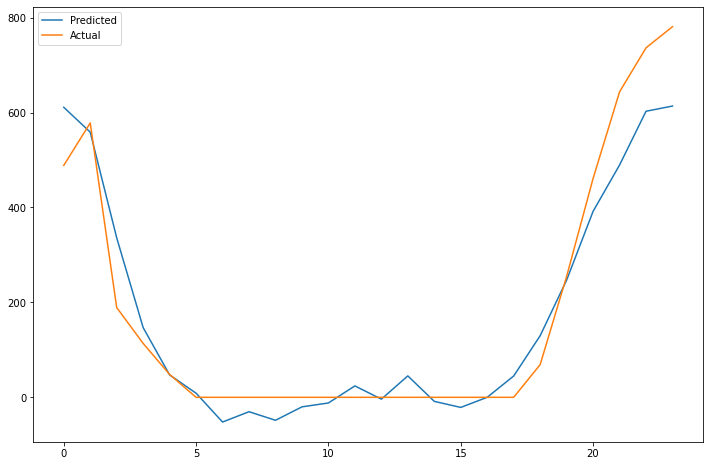

In [35]:
plt.plot(y_pred[-1],label='Predicted')
plt.plot(y_test[-1],label='Actual')
plt.legend()

In [31]:
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = keras.metrics.mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores


### RMSE score for each window value

for example if we are predicting 10 points in future, we will get the rmse for ith day,i+1th day, ... i+9th day and so

In [32]:
evaluate_forecasts(y_test,y_pred)

(89.15779682430801,
 [72.05811,
  84.59676,
  102.41335,
  92.02548,
  105.3227,
  89.241234,
  92.414764,
  86.25057,
  89.161644,
  88.71867,
  83.18975,
  95.71259,
  88.90705,
  83.92888,
  89.90456,
  92.9368,
  84.55655,
  82.11985,
  83.42864,
  84.73028,
  86.844635,
  91.636185,
  90.782684,
  93.01329])

In [33]:
y_test.shape

(388, 24)